### first version

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan  8 09:46:35 2021

@author: 10911110
"""
import cv2 
import os
import numpy as np
import shutil

debug = False
kernel = np.ones((3,3), np.uint8)
kernel2 = np.ones((3,3), np.uint8)

def Debug_ShowImage(image, string):
    cv2.imshow(string, image)
    cv2.waitKey(0)

def fillHole(image):
    tmp = image.copy()
    cv2.floodFill(tmp,None, (0,0), 255)
    hole=cv2.bitwise_not(tmp)
    return (hole | image)

def GetWordImage(img):
    
    h,w,d = img.shape
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    if gray.mean()<60 :
        return None

    #%%找標籤
    
    brightTh,brightArea = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    if brightTh<130 and gray.mean()>180 :
        return None

    brightArea = cv2.morphologyEx(brightArea, cv2.MORPH_OPEN, kernel2) #去掉邊緣連著的鬚鬚
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(brightArea)
        
    temp = 0
    for i in range(1,np.max(labels)+1):
    
        if np.count_nonzero(labels==i) > temp:
            max_ele = i
            temp = np.count_nonzero(labels==i)
        
    MaxBrightArea = cv2.inRange(labels, max_ele, max_ele)
    if stats[max_ele][2]*stats[max_ele][3]>stats[max_ele][4]*5 or stats[max_ele][4]<20000:
        return None
    
    MaxBrightArea_Fill = fillHole(MaxBrightArea) #填滿的label

    BlackAreaInLabel = cv2.bitwise_not(MaxBrightArea_Fill) | MaxBrightArea 

    #%% 去barcode
    BlackAreaInLabel = cv2.bitwise_not(BlackAreaInLabel)
       
    BlackAreaInLabelDilate = cv2.dilate(BlackAreaInLabel,kernel)
    
    buffer = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    val, labels_im, stats, centroids = cv2.connectedComponentsWithStats(BlackAreaInLabelDilate)
    
    FindQR = False
    for i in range(1,np.max(labels_im)+1):
        tmp =cv2.inRange(labels_im, i, i)
        ratio = stats[i][2]/stats[i][3] if stats[i][2]<stats[i][3] else stats[i][3]/stats[i][2]
        
        x1 = stats[i][0]
        y1 = stats[i][1]
        x2 = stats[i][0]+stats[i][2]-1
        y2 = stats[i][1]+stats[i][3]-1
        
        if stats[i][2]>h*3/4 or stats[i][3]>w*3/4:
            continue
        
        if ((ratio>0.95) and stats[i][4] > 10000) or stats[i][4] > 20000: 
            tmp = cv2.dilate(tmp,kernel)
            buffer = buffer | tmp
            FindQR = True
            continue
        
        contours, hierarchy = cv2.findContours(tmp,cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)
        rect = cv2.minAreaRect(contours[0])
        
        if (stats[i][4]/(rect[1][0]*rect[1][1]+0.00001)>0.9) and stats[i][4] > 2000:
            tmp = cv2.dilate(tmp,kernel)
            buffer = buffer | tmp
            FindQR = True
            continue

    if FindQR :
        buffer =cv2.bitwise_and( MaxBrightArea_Fill, cv2.bitwise_not(buffer))
    else:
        buffer = MaxBrightArea_Fill
    
   
    #%% 找邊緣   
    const = 11
    mg_b = cv2.GaussianBlur(img[:,:,0], (const, const), 0)
    mg_g = cv2.GaussianBlur(img[:,:,1], (const, const), 0)
    mg_r = cv2.GaussianBlur(img[:,:,2], (const, const), 0)

    cannyB = cv2.Canny(mg_b, 80, 60)
    cannyG = cv2.Canny(mg_g, 80, 60)
    cannyR = cv2.Canny(mg_r, 80, 60)
    
    canny = cannyB | cannyG | cannyR
    
    canny =cv2.bitwise_and( canny, buffer)
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(canny)
    
    select = np.zeros((img.shape[0], img.shape[1]), np.uint8)

    for i in range(1, num_labels):
    
        if stats[i][2] < 15 or stats[i][3]< 15 :
            continue

        mask = labels == i
        select[mask] = 255
    
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(select)
    output = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    
    #%%local threshold
    for i in range(1, num_labels):
        if (stats[i][4]<50 or stats[i][4]>(h*w/3) or stats[i][2]>h/2 or stats[i][3]>w/2 ):
            continue
        tmp =cv2.inRange(labels, i, i)
        contours, hierarchy = cv2.findContours(tmp,cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)

        x1 = stats[i][0]
        y1 = stats[i][1]
        x2 = stats[i][0]+stats[i][2]-1
        y2 = stats[i][1]+stats[i][3]-1

        mask = np.zeros((img.shape[0], img.shape[1]), np.uint8)
        
        cv2.drawContours(mask,contours,-1,255,1)
        
        edge_mean ,std = cv2.meanStdDev(gray,mask = mask)
        
        cv2.rectangle(mask, (x1, y1), (x2,y2), 255, -1)
        
        mask2 = np.zeros((img.shape[0], img.shape[1]), np.uint8)
        cv2.rectangle(mask2, (x1, y1), (x2,y2), 255, 1)
        box_mean ,std = cv2.meanStdDev(gray, mask =mask2)
        
        if box_mean<edge_mean:
            continue
    
        src = cv2.bitwise_and(mask, gray)
        
        threshold_img  = cv2.inRange(src, 1, int((box_mean+edge_mean)/2))
        
        output = threshold_img |output

    if cv2.countNonZero(output) > 1000:
        return output
    else:
        return None

(820, 1086, 3) [82 73 53]


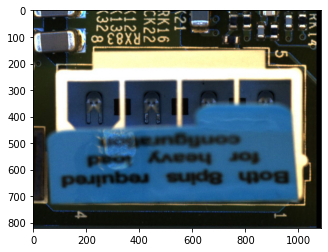

In [2]:
import cv2
import matplotlib.pyplot as plt
img_path = '/data/aoi-wzs-p1-dip-fa-nvidia/data-center/D11/OK/2020-06-12/555019010084024000BEJ0E1_LABELJPWR1_180_000_000_000_000_000.jpg'
image = cv2.imread(img_path)
print(image.shape, image[0,0,:])
plt.imshow(image)


(820, 1086) [0 0 0 ... 0 0 0]


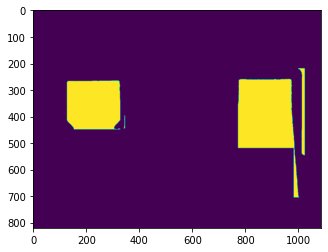

In [3]:
result = GetWordImage(image)
if result is not None:
    print(result.shape, result[0,:])
    plt.imshow(result)

In [15]:
import tensorflow as tf
pre_ed = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/NG/15-555019010084024000BEJ0E1_LABELJPWR1_180_000_000_000_000_000.jpg'
x = tf.io.read_file(pre_ed)
x = tf.io.decode_jpeg(x,channels=1,dct_method='INTEGER_ACCURATE',try_recover_truncated=True)
x = x.numpy()[0]
x

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

## dealing with mysql

In [1]:
import mysql.connector
mydb = mysql.connector.connect(
    host="10.41.241.230",
    port="30003",
    user="aoi_ai",
    password="finding_way_out",
    database="P1")
c = mydb.cursor()

In [4]:
import random
import shutil
import os
import cv2
from LabelClass import Preprocessing
none_results = {'NG':[], '000':[], '090':[], '180':[], '270':[]}
black_results = {'NG':[], '000':[], '090':[], '180':[], '270':[]}
for degree in ['NG', '000', '090', '180', '270']:
    if degree=='NG':
        c.execute(f"select * from dip_fa where component='label' and label='{degree}'")
    else:
        c.execute(f"select * from dip_fa where component='label' and label='OK' and degree='{degree}'")
    paths = c.fetchall()
    print(f'all images of {degree}: {len(paths)}')
    
    target_dir = f'/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/{degree}/'
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    for path in paths:
        filename = os.path.split(path[0])[-1]
        shutil.copy(path[0], os.path.join(target_dir,f'{path[8]}+{filename}'))

#     target_dir = f'/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/jan_test/{degree}/'
#     if not os.path.exists(target_dir):
#         os.makedirs(target_dir)

    for path in paths:
        filename = os.path.split(path[0])[-1]
        image = cv2.imread(path[0])
        preprocessing = Preprocessing(image)
        result = preprocessing.run()
        if os.path.isfile(os.path.join(target_dir,filename)):
            target = os.path.join(target_dir,f'{str(random.randrange(100))}-{filename}')
        else:
            target = os.path.join(target_dir,filename)
        if result is not None:
            if cv2.countNonZero(result) != 0:
                cv2.imwrite(target,result)
            else:
                black_results[degree].append(path[0])
        else:
            none_results[degree].append(path[0])
    print(f'none images of {degree}: {len(none_results[degree])}\nblack images of {degree}: {len(black_results[degree])}')
    print('-----')

all images of NG: 1374
none images of NG: 1313
black images of NG: 0
-----
all images of 000: 16932
none images of 000: 15
black images of 000: 0
-----
all images of 090: 1717
none images of 090: 0
black images of 090: 0
-----
all images of 180: 2719
none images of 180: 64
black images of 180: 0
-----
all images of 270: 2521
none images of 270: 3
black images of 270: 0
-----


#### move none & black to folder

In [6]:
import shutil
base_tar = '/data/aoi-wzs-p1-dip-fa-nvidia/5class_missed_label/'
# shutil.rmtree(base_tar)
for key, value in none_results.items():
    if not os.path.exists(os.path.join(base_tar,'newNone',key)):
        os.makedirs(os.path.join(base_tar,'newNone',key))
    print(key, len(value))
    for v in value:
        filename = os.path.split(v)[-1]
        shutil.copyfile(v, os.path.join(base_tar,'newNone',key,filename))

NG 32
000 1
090 0
180 0
270 0


In [9]:
base_tar = '/data/aoi-wzs-p1-dip-fa-nvidia/5class_missed_label/'
for key, value in black_results.items():
    if not os.path.exists(os.path.join(base_tar,'Black',key)):
        os.makedirs(os.path.join(base_tar,'Black',key))
    print(key, len(value))
    for v in value:
        filename = os.path.split(v)[-1]
        shutil.copyfile(v, os.path.join(base_tar,'Black',key,filename))

NG 0
000 0
090 0
180 0
270 0


#### to tfrecord

In [1]:
import tensorflow as tf
import os
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(value):
    features = {
#         "image": _bytes_feature(tf.io.read_file(value[0]).numpy()),
        "path": _bytes_feature(tf.constant(value[0]).numpy()),
        "label": _bytes_feature(tf.constant(value[1]).numpy()),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=features))
    return example_proto.SerializeToString()

target = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/preprocessed/LabelOrientationGenerateImage/'
tfrecord_base = '/data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/LabelOrientationGenerateImage/'
for label in os.listdir(target):
    with tf.io.TFRecordWriter(f'{tfrecord_base}{label}.tfrecord') as writer:    
        for fn in os.listdir(os.path.join(target,label)):
            example = serialize_example([os.path.join(target,label,fn), label])
            writer.write(example)
        print('Exported Successfully to '+f'{tfrecord_base}{label}.tfrecord')

Exported Successfully to /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/LabelOrientationGenerateImage/000.tfrecord
Exported Successfully to /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/LabelOrientationGenerateImage/180.tfrecord
Exported Successfully to /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/LabelOrientationGenerateImage/270.tfrecord
Exported Successfully to /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/LabelOrientationGenerateImage/090.tfrecord
Exported Successfully to /data/aoi-wzs-p1-dip-fa-nvidia/label_heatsink_screw/tfrecord/LabelOrientationGenerateImage/NG.tfrecord


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def parse_example(example_proto):    
    image_feature_description = {
        "path": tf.io.FixedLenFeature([], tf.string),
#         "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string),
    }
    features_in_example = tf.io.parse_single_example(example_proto, image_feature_description)
    features = {
        'path': features_in_example['path'],
#         'image': features_in_example['image'],
        'label': features_in_example['label'],
    }
    return features

for tfr in os.listdir(tfrecord_base):
    ds = tf.data.TFRecordDataset(f'{tfrecord_base}{tfr}').map(parse_example, AUTOTUNE)
    print(tfr, [i for i,_ in enumerate(ds)][-1] + 1)

000.tfrecord 15873
180.tfrecord 2560
090.tfrecord 1702
NG.tfrecord 141
270.tfrecord 2021


### first version

In [19]:
import cv2 
import numpy as np
import os
from math import atan2,degrees
import sqlite3
conn = sqlite3.connect('/data/robert/training/p1-dip-metadata.db')
c = conn.cursor()
label_paths = c.execute("select path, degree from metadata where component_class='label' and label='OK' order by width desc").fetchall()
len(label_paths)

21577

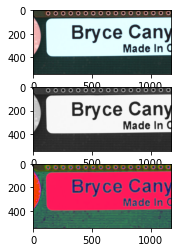

In [24]:
import matplotlib.pyplot as plt
image = cv2.imread(label_paths[1000][0])
Gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
plt.figure(1)
plt.subplot(311)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.subplot(312)
plt.imshow(cv2.cvtColor(Gray, cv2.COLOR_BGR2RGB))
plt.subplot(313)
plt.imshow(cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB))
plt.show()

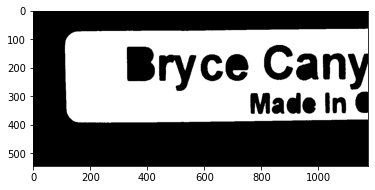

In [27]:
# 白色區域
def FillHole(image):
    tmp = image.copy()
    cv2.floodFill(tmp,None, (0,0), 255)
    hole=cv2.bitwise_not(tmp)
    return (hole | image)

def GetLargestComponents(mask):
    num_labels, labels_im = cv2.connectedComponents(mask)
    temp = 0
    for i in range(1, num_labels):
        if np.count_nonzero(labels_im==i) > temp:
            max_ele = i
            temp = np.count_nonzero(labels_im==i)
    return cv2.inRange(labels_im, max_ele, max_ele)

whiteTH = 230
mask_white = cv2.inRange(Gray, whiteTH, 255)
mask_white = GetLargestComponents(mask_white)
# tmp = mask_white.copy()
# cv2.floodFill(tmp,None, (0,0), 255)
plt.imshow(cv2.cvtColor(mask_white, cv2.COLOR_BGR2RGB))
# mask_white = FillHole(mask_white)

In [ ]:
#%% Function
def FindCenter(image):
    M_white = cv2.moments(image)
    cX = int(M_white["m10"] / M_white["m00"])
    cY = int(M_white["m01"] / M_white["m00"])
    return(cX,cY)

def AngleBtw2Points(pointA, pointB):
    changeInX = pointB[0] - pointA[0]
    changeInY = pointB[1] - pointA[1]
    return degrees(atan2(changeInY,changeInX))

def FindDegree(filePath):
    # 字的區域
    ROI_White = cv2.bitwise_and(Gray,Gray,mask = mask_white)
    mask_Num = cv2.inRange(ROI_White, 100, whiteTH)
    
    # 標記的區域(半魚眼)
    mean , std = cv2.meanStdDev(image,mask = mask_Num)
    hsv_mean , hsv_std = cv2.meanStdDev(hsv,mask = mask_Num)
    
    if debug:
        print(mean)
        print(std)
        print(hsv_mean)
        print(hsv_std)
        
    sRange = [hsv_mean[1][0]-2*hsv_std[1][0],hsv_mean[1][0]+2*hsv_std[1][0]]
    vRange = [hsv_mean[2][0]-2*hsv_std[2][0],hsv_mean[2][0]+2*hsv_std[2][0]]
    
    if (mean[2][0]-mean[0][0]>10 and mean[2][0]-mean[1][0]>10): #紅色      
        lower_red_0 = np.array([0, sRange[0], vRange[0]])
        upper_red_0 = np.array([15, sRange[1], vRange[1]])
        lower_red_1 = np.array([165, sRange[0], vRange[0]])
        upper_red_1 = np.array([180, sRange[1], vRange[1]])
        red_mask0 = cv2.inRange(hsv, lower_red_0, upper_red_0)
        red_mask1 = cv2.inRange(hsv, lower_red_1, upper_red_1)
        mask_label = cv2.bitwise_or(red_mask0, red_mask1) 
    else: #藍綠色
        lower_bound = np.array([hsv_mean[0][0]-3*hsv_std[0][0], sRange[0], vRange[0]])
        upper_bound = np.array([hsv_mean[0][0]+3*hsv_std[0][0], sRange[1], vRange[1]])
        mask_label = cv2.inRange(hsv, lower_bound, upper_bound)
        
    mask_label = GetLargestComponents(mask_label)
    mask_label = FillHole(mask_label)

    if debug:
        cv2.imshow("image", image)
        cv2.imshow("mask_label", mask_label)
        cv2.imshow("mask_white", mask_white)
        cv2.imshow("mask_Num", mask_Num)
        cv2.waitKey(0)
        
    #找重心
    label_center = FindCenter(mask_label)
    white_center = FindCenter(mask_white)

    return AngleBtw2Points(label_center,white_center)